In [1]:
#<img src="Figs/GEOS_logo.pdf" width="500"/>

# Statistical testing tools for synthetic data sets: 
## <font color=blue>"stat_synthetic.ipynb"</font>
#### March 12, 2022  <font color=red>(v. testing)</font>
##### Jeonghyeop Kim (jeonghyeop.kim@gmail.com)

1. This code is a part of the joint inversion project (project4: joint inversion of GNSS and InSAR)

2. The followings will be plotted and saved:
- The "L-curve"
- The misfit of 3-D motion as a function of damping parameters ("heatmap")
- The misfit of data vector as a function of damping parameters ("heatmap")

**`Note that a "true" 3-D field is only available for synthetic data sets`**


In [2]:
## Import libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import LineCollection
import seaborn as sns

%matplotlib inline

In [3]:
## Initialization

inversion_type='L2'  #'L1' or 'L2'
subdir_name = 'input_files'+'_'+inversion_type # the name of a subdirectory where your input files are

cwd = os.getcwd()
path = os.path.join(cwd, subdir_name)

print("Statistical tests for the %s inversion results.\n" %inversion_type)
print("%s_stat* & %s_model_coef* files must be in the following directory:\n" %(inversion_type,inversion_type))
print("'%s'" %path)

## Assign a list of names made of param.

if inversion_type=='L2':     
    names=['wI', 'wG', 'alpha','beta']
    
elif inversion_type=='L1':
    names=['wI', 'wG', 'alpha']    
    
else: #stop the code
    print(" ********************************************** ")
    print(" * inversion_type must be either 'L2' or 'L1' * ")      
    print(" ********************************************** ")

    exit() 

Statistical tests for the L2 inversion results.

L2_stat* & L2_model_coef* files must be in the following directory:

'/Users/jkim/main/Joint_GNSS_INSAR/statistical_testing_tools_02282022/input_files_L2'


In [4]:
## Define ComputeModelNorm function
## If the type of inversion is L2, the output model norm will be squared

def ComputeModelNorm(model_arr,inversion='L2'):
    
    if inversion=='L2':
        norm_type=2
        model_norm = np.linalg.norm(model_arr,norm_type)**2
        
    else:
        norm_type=1
        model_norm = np.linalg.norm(model_arr,norm_type)
     
    return model_norm

In [5]:
## Define MakeFileName function 

def MakeFileName(head,ext,paramList):
    
    glue = '_'
    paramList_glue = glue.join(paramList)
    filename = head + paramList_glue + ext
    
    return filename

In [6]:
## Define MisfitTrueField function

def MisfitTrueField(h_true_arr, h_pred_arr, v_true_arr, v_pred_arr):
    """
    h = horizontal
    v = vertical
    """
    dx = (h_true_arr-h_pred_arr)[:,2]
    dx_squared = dx**2
    dx_squared_sum = np.sum(dx_squared)

    dy = (h_true_arr-h_pred_arr)[:,3]
    dy_squared = dy**2
    dy_squared_sum = np.sum(dy_squared)

    dz = (v_true_arr-v_pred_arr)[:,2]
    dz_squared = dz**2
    dz_squared_sum = np.sum(dz_squared)

    dhori_squared_sum = dx_squared_sum + dy_squared_sum 

    d3D_squared_sum = dhori_squared_sum + dz_squared_sum
    
    return dx_squared_sum, dy_squared_sum, dz_squared_sum, dhori_squared_sum, d3D_squared_sum

In [7]:
## Extract all combinations of the parameter variables 

### wI : relative weighting for InSAR
### wG : relative weighting for GNSS
### alpha : 1st regularization param. 
### beta  : 2nd regularization param. (for L2 only)

load_params = []
scan_file = inversion_type+'_stat_'

if inversion_type=='L2':
    
    with os.scandir(path) as it: #scan the directory
        for entry in it:
            if entry.name.startswith(scan_file) and entry.is_file():
                element1=entry.name.split("_")[2:][0]
                element2=entry.name.split("_")[2:][1]
                element3=entry.name.split("_")[2:][2]
                element4=entry.name.split("_")[2:][-1][0:-4] 
                # [0:-4] means without extension (e.g., .dat or .txt)
                list_elements = [element1, element2, element3, element4]
                load_params.append(list_elements)

elif inversion_type=='L1':
    
    with os.scandir(path) as it: #scan the directory
        for entry in it:
            if entry.name.startswith(scan_file) and entry.is_file():
                element1=entry.name.split("_")[2:][0]
                element2=entry.name.split("_")[2:][1]
                element3=entry.name.split("_")[2:][-1][0:-4]
                # [0:-4] means without extension(e.g., .dat or .txt)
                list_elements = [element1, element2, element3]
                load_params.append(list_elements)        
    
df_param_string = pd.DataFrame(load_params,columns=names)
df_param_numeric = df_param_string.astype(float)

In [9]:
%%time

## Computing model norms and data misfits
## It will take time (~15 minutes)

model_norms = [] # model norms
misfits = [] # misfit for data

misfits_x = [] # misfit for "true" field (x)
misfits_y = [] # misfit for "true" field (y)
misfits_z = [] # misfit for "true" field (z)
misfits_horizontal = [] # misfit for "true" field (x & y)
misfits_3_D = [] # misfit for "true" field (x & y & z)

v_true_arr = np.loadtxt(path+'/vel_vertical_scaled.gmt') # Load True Field 
h_true_arr = np.loadtxt(path+'/vel_horizontal_cont.gmt') # Load True Field 

for i in range(len(df_param_string)):
    paramList=df_param_string.iloc[i,:].values
    
    ## Calculate & save model norms
    head = inversion_type + '_model_coef_'
    ext = '.dat'
    filename_model=MakeFileName(head,ext,paramList)
    model_arr = np.loadtxt(path+'/'+filename_model)
    model_norm=ComputeModelNorm(model_arr,inversion=inversion_type)
    model_norms.append(model_norm)
    
    ## Save inversion misfits DATA
    head = inversion_type + '_stat_'
    ext = '.txt'
    filename_stat=MakeFileName(head,ext,paramList)
    stat_arr = np.loadtxt(path+'/'+filename_stat)
    misfits.append(float(stat_arr))
        
    ## SAVE inversion misfits "TRUE"  
    head = inversion_type + '_vel_vertical_cont_pred_'
    ext = '.dat'
    filename_model=MakeFileName(head,ext,paramList)
    v_pred_arr = np.loadtxt(path+'/'+filename_model)
        
    ## horizontal
    head = inversion_type + '_vel_horizontal_cont_pred_'
    ext = '.gmt'
    filename_stat=MakeFileName(head,ext,paramList)
    h_pred_arr = np.loadtxt(path+'/'+filename_stat)

    mx,my,mz,mh,m3 = MisfitTrueField(h_true_arr, h_pred_arr, v_true_arr, v_pred_arr)
    
    misfits_x.append(mx)
    misfits_y.append(my)
    misfits_z.append(mz)
    misfits_horizontal.append(mh)
    misfits_3_D.append(m3)
    
    
df_param_numeric['model_norm'] = model_norms 
df_param_numeric['misfit_data'] = misfits # misfits are squared sum of 'G m - d'
df_param_numeric['misfit_x_true'] = misfits_x # misfits are squared sum of 'Gc m - true'
df_param_numeric['misfit_y_true'] = misfits_y # misfits are squared sum of 'Gc m - true'
df_param_numeric['misfit_z_true'] = misfits_z # misfits are squared sum of 'Gc m - true'
df_param_numeric['misfit_hori_true'] = misfits_horizontal # misfits are squared sum of 'Gc m - true'
df_param_numeric['misfit_3D_true'] = misfits_3_D # misfits are squared sum of 'Gc m - true'

CPU times: user 13min 1s, sys: 10.4 s, total: 13min 12s
Wall time: 13min 36s


### (1). PLOTS
- (a) Fix wI & wG values for each subplot -> **models norm vs. data misfit (L-curve)** 
- (b) Fix wI & wG values for each subplot -> **alpha-beta vs. data misfit (Heatmap)**

### (2). ADDITIONAL PLOTS for synthetic data,
- (a) Fix wI & wG values for each subplot -> **models norm vs. 3-D field misfit (L-curve)**
- (b) Fix wI & wG values for each subplot -> **alpha-beta vs. 3-D misfit (Heatmap)**

In [294]:
## dictionary for columns and unique values pairs 
dict_unique = {} 
for col in names: 
    unique_values = pd.unique(df_param_numeric[col].sort_values(ascending=True)).tolist()
    dict_unique["{0}".format(col)] = unique_values

#### (1)-(a). PLOTS

In [295]:
def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [296]:
ncols = len(dict_unique['wI'])
nrows = len(dict_unique['wG'])

for col in range(ncols): #wI = constant
    for row in range(nrows): #wG = constant
        wI_search = dict_unique['wI'][col]
        wG_search = dict_unique['wG'][row]
        df_search = df_param_numeric[(df_param_numeric.wI == wI_search) & (df_param_numeric.wG == wG_search)]
    
        if inversion_type == 'L2':
            df_search = df_search.sort_values(['beta', 'alpha'], ascending=True)
            df_search = df_search.reset_index(drop=True)
            
        else: ## elif inversion_type == 'L1':        
            df_search = df_search.sort_values(['alpha'], ascending=True)
            df_search = df_search.reset_index(drop=True)

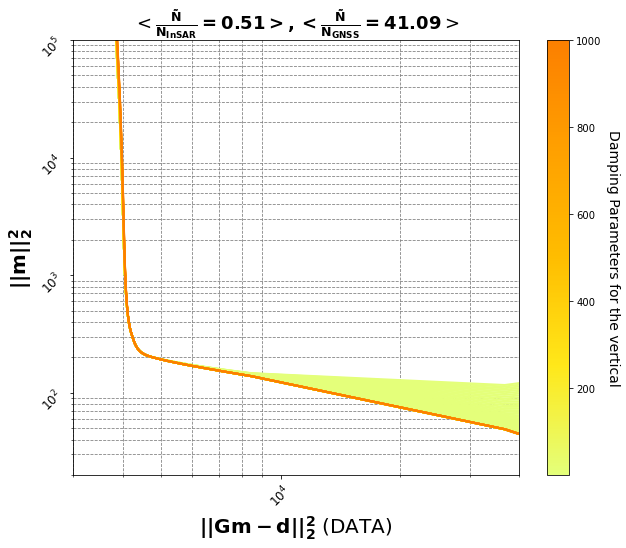

In [297]:
y=df_search.groupby('beta').model_norm.apply(np.array).values
ys=np.stack( y, axis=0 )

x=df_search.groupby('beta').misfit_data.apply(np.array).values
xs=np.stack( x, axis=0 )

yint = np.array(dict_unique['beta'])

fig, ax = plt.subplots(figsize=(10,8))

lc = multiline(xs, ys, yint, cmap='Wistia', lw=2, ls='-')
# magma_r; Wistia
# ax.plot(df_search['misfit_data'], df_search['model_norm'], 'x', markersize=10, 
#          markeredgecolor='black',markerfacecolor='none', alpha=0.2, markeredgewidth = 0.2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, color='0.5',linestyle='--', which='minor')
ax.set_xlabel(r'$\mathbf{\vert\vert Gm-d \vert\vert_2^2}$ (DATA)', fontsize=20)
ax.set_ylabel(r'$\mathbf{\vert\vert m \vert\vert_2^2}$', fontsize=20)
ax.tick_params(axis='x', labelsize=12, rotation=45, which='both')
ax.tick_params(axis='y', labelsize=12, rotation=45, which='both') 
ax.set_xlim([3*10**3,4*10**4])
ax.set_ylim([2*10**1,10**5])

ax.set_title(r'$<\mathbf{\frac{\~ N}{N_{InSAR}}=%0.2f>, <\frac{\~ N}{N_{GNSS}}=%0.2f}>$' 
             % (1/(wI_search**2), 1/(wG_search**2)), fontsize=18)
axcb = fig.colorbar(lc)
axcb.set_label('Damping Parameters for the vertical', rotation=270, labelpad=18, fontsize=14)

fig.savefig('L-curve.pdf')

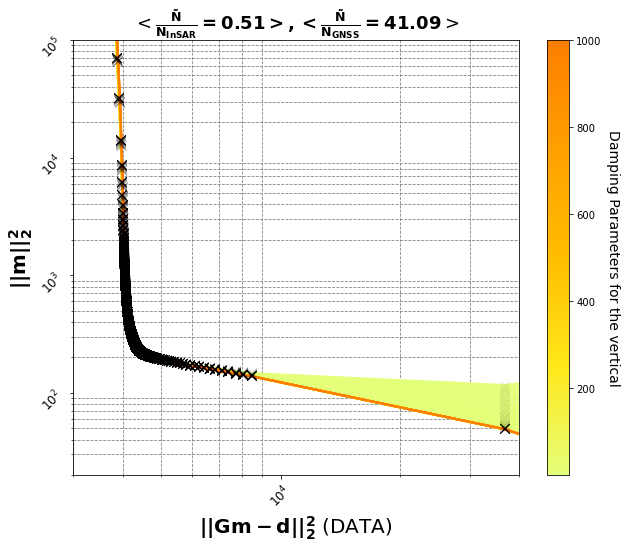

In [298]:
y=df_search.groupby('beta').model_norm.apply(np.array).values
ys=np.stack( y, axis=0 )

x=df_search.groupby('beta').misfit_data.apply(np.array).values
xs=np.stack( x, axis=0 )

yint = np.array(dict_unique['beta'])

fig, ax = plt.subplots(figsize=(10,8))

lc = multiline(xs, ys, yint, cmap='Wistia', lw=2, ls='-')
# magma_r; Wistia
ax.plot(df_search['misfit_data'], df_search['model_norm'], 'x', markersize=10, 
         markeredgecolor='black',markerfacecolor='none', alpha=0.2, markeredgewidth = 0.2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, color='0.5',linestyle='--', which='minor')
ax.set_xlabel(r'$\mathbf{\vert\vert Gm-d \vert\vert_2^2}$ (DATA)', fontsize=20)
ax.set_ylabel(r'$\mathbf{\vert\vert m \vert\vert_2^2}$', fontsize=20)
ax.tick_params(axis='x', labelsize=12, rotation=45, which='both')
ax.tick_params(axis='y', labelsize=12, rotation=45, which='both') 
ax.set_xlim([3*10**3,4*10**4])
ax.set_ylim([2*10**1,10**5])

ax.set_title(r'$<\mathbf{\frac{\~ N}{N_{InSAR}}=%0.2f>, <\frac{\~ N}{N_{GNSS}}=%0.2f}>$' 
             % (1/(wI_search**2), 1/(wG_search**2)), fontsize=18)
axcb = fig.colorbar(lc)
axcb.set_label('Damping Parameters for the vertical', rotation=270, labelpad=18, fontsize=14)

fig.savefig('L-curve_with_x.pdf')

In [212]:
alpha = np.logspace(0,2,500)

In [213]:
## SPLINE FIT
from scipy import interpolate

def f_spline(func_discrete, der_degree=0):

    x = np.array(dict_unique['alpha'])
    x2 = np.logspace(0,2,500)
    tck = interpolate.splrep(x, func_discrete)
    
    return interpolate.splev(x2, tck, der=der_degree)

In [214]:
def menger_curvature(X,Y):
    """
    This function calculates the Menger curvature.
    X, Y : arrays in the same dimension.
    """
    
    ## check if the two variables have the same length.
    N = len(X)
    N_test = len(Y)
    
    if N != N_test:
        print("The two variables must have the same length.")
        return -1
    
    ## make an initial curvature array
    curvatures = np.zeros((N,))*np.nan

    ## calculate menger curvatures 
    for i in range(1,N-1):
        
        Numerator = (X[i-1]*Y[i] + X[i]*Y[i+1] + X[i+1]*Y[i-1] 
                     - X[i-1]*Y[i+1] - X[i]*Y[i-1] - X[i+1]*Y[i]) 
        Numerator = 2 * Numerator
     
        Distance1 = np.sqrt((X[i-1]-X[i])**2 + (Y[i-1]-Y[i])**2)
        Distance2 = np.sqrt((X[i]-X[i+1])**2 + (Y[i]-Y[i+1])**2)
        Distance3 = np.sqrt((X[i+1]-X[i-1])**2 + (Y[i+1]-Y[i-1])**2)
    
        Denominator = Distance1 * Distance2 * Distance3
        
        Ci = Numerator/Denominator
        curvatures[i]=Ci
        
    return curvatures  

In [215]:
def min_product(X,Y):
    """
    This function calculates the product 
    proposed by Lian et al. 1998
    X, Y : arrays in the same dimension.
    """
    
    ## check if the two variables have the same length.
    N = len(X)
    N_test = len(Y)
    
    if N != N_test:
        print("The two variables must have the same length.")
        return -1
    
    P = X*Y
    
    return P

In [216]:
def Hansen_curvature(alpha, d_f1, dd_f1, d_f2, dd_f2):
        
    curvatures = (d_f1 * dd_f2 - dd_f1 * d_f2) / (((d_f1)**2 + (d_f2)**2)**3/2)
    
    return curvatures

In [217]:
def CRESO(alpha, f1, d_f1):

    creso_function = f1 + 2 * alpha * d_f1
    
    return creso_function

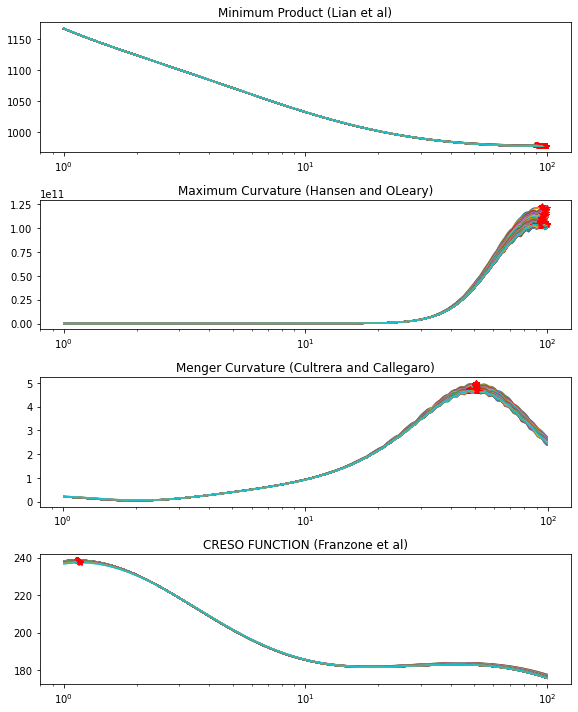

In [218]:
fig, ax = plt.subplots(figsize=(8,10), ncols=1, nrows=4)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')


ax[0].set_title('Minimum Product (Lian et al)')
ax[1].set_title('Maximum Curvature (Hansen and O''Leary)')
ax[2].set_title('Menger Curvature (Cultrera and Callegaro)')
ax[3].set_title('CRESO FUNCTION (Franzone et al)')
fig.tight_layout()



for i in range(len(xs)):
    
    # FIT Spline   
    X_spline = f_spline(xs[i,:], der_degree=0)
    Y_spline = f_spline(ys[i,:], der_degree=0)
    X_spline_d = f_spline(np.log(np.sqrt(xs[i,:])), der_degree=1)
    Y_spline_d = f_spline(np.log(np.sqrt(ys[i,:])), der_degree=1)
    X_spline_dd = f_spline(np.log(np.sqrt(xs[i,:])), der_degree=2)
    Y_spline_dd = f_spline(np.log(np.sqrt(ys[i,:])), der_degree=2)    

    
    
    #PLOT MIN PRODUCTs
    X=np.sqrt(X_spline)
    Y=np.sqrt(Y_spline)
    P=min_product(X,Y)
    ax[0].plot(alpha,P,'-')
    ax[0].plot(alpha[np.argmin(P)],P[np.argmin(P)],'r*')
    
    
    #PLOT MAX CURVATUREs
    curvatures=Hansen_curvature(alpha, X_spline_d, X_spline_dd, Y_spline_d, Y_spline_dd)
    ax[1].plot(alpha,curvatures,'-')
    ax[1].plot(alpha[np.argmax(curvatures)], curvatures[np.argmax(curvatures)], 'r*')
    
    
    #PLOT MAX Menger CURVATUREs
    X=np.log(X_spline)
    Y=np.log(Y_spline)
    curv1=menger_curvature(X,Y)
    ax[2].plot(alpha,curv1,'-')
    ax[2].plot(alpha[np.nanargmax(curv1)],curv1[np.nanargmax(curv1)],'r*')
    
    ##PLOT CRESO FUNCTION
    Y_spline_CRESO = f_spline(ys[i,:], der_degree=0)
    Y_spline_d_CRESO = f_spline(ys[i,:], der_degree=1)
    creso_function = CRESO(alpha, Y_spline_CRESO, Y_spline_d_CRESO)
    ax[3].plot(alpha,creso_function,'-')
    ax[3].plot(alpha[np.nanargmax(creso_function)],creso_function[np.nanargmax(creso_function)],'r*')
    #ax[3].set_ylim([200, 300])

# NONE OF THE EQUATIONS PREDICT THE "OPTIMAL" PARAMETER 

In [190]:
# https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

#### (1)-(b). PLOTS

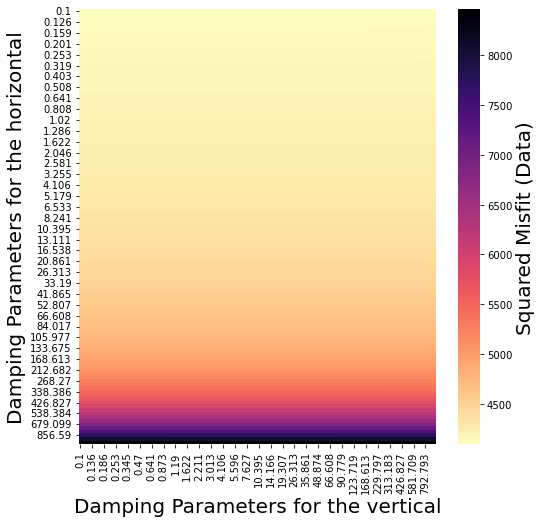

In [300]:
df_misfit = df_search.loc[:,['alpha','beta','misfit_data']]

scale = 1
tickFont = 20
fig, ax = plt.subplots(figsize = (8*scale,8*scale), ncols = ncols, nrows = nrows, sharex=True, sharey=True)
df_misfit_zoomed = df_misfit[(df_misfit['alpha'] <= 1000) & (df_misfit['alpha'] >= 0.1)]
df_misfit_zoomed = df_misfit_zoomed.pivot_table(index='alpha', columns='beta', values='misfit_data')
ax = sns.heatmap(df_misfit_zoomed, cmap='magma_r')
ax.figure.axes[-1].set_ylabel('Squared Misfit (Data)', size=20)

plt.ylabel('Damping Parameters for the horizontal', fontsize=20)
plt.xlabel('Damping Parameters for the vertical', fontsize=20)
fig.savefig('HeatMap_DATA.pdf')

In [ ]:
# ax = sns.heatmap(df_misfit_zoomed, cmap='magma_r')
# ax.figure.axes[-1].set_ylabel('Squared Misfit (Data)', size=20)

#### (2)-(a). PLOTS

In [233]:
df_search.columns

Index(['wI', 'wG', 'alpha', 'beta', 'model_norm', 'misfit_data',
       'misfit_x_true', 'misfit_y_true', 'misfit_z_true', 'misfit_hori_true',
       'misfit_3D_true'],
      dtype='object')

In [242]:
xs.shape

(120, 188)

Optimal alpha is 14.166000


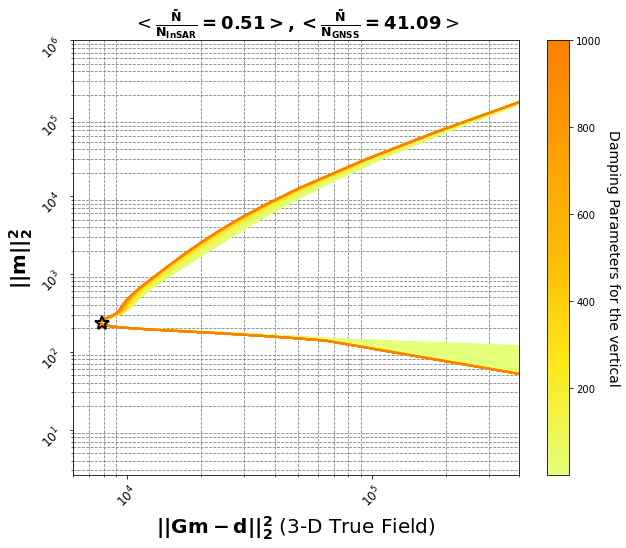

In [287]:
y=df_search.groupby('beta').model_norm.apply(np.array).values
ys=np.stack( y, axis=0 )

x=df_search.groupby('beta').misfit_3D_true.apply(np.array).values
xs=np.stack( x, axis=0 )

yint = np.array(dict_unique['beta'])

fig, ax = plt.subplots(figsize=(10,8))

lc = multiline(xs, ys, yint, cmap='Wistia', lw=2, ls='-')
# magma_r; Wistia


Nmin=np.argmin(xs,axis=1)
MinAlpha_median_idx=int(np.median(Nmin))
MinAlpha_median=dict_unique['alpha'][MinAlpha_median_idx]
print("Optimal alpha is %f" % MinAlpha_median)

ax.plot(df_search['misfit_3D_true'][MinAlpha_median_idx], df_search['model_norm'][MinAlpha_median_idx], '*', markersize=15, 
         markeredgecolor='black',markerfacecolor='none', alpha=1, markeredgewidth = 2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, color='0.5',linestyle='--', which='minor')
ax.set_xlabel(r'$\mathbf{\vert\vert Gm-d \vert\vert_2^2}$ (3-D True Field)', fontsize=20)
ax.set_ylabel(r'$\mathbf{\vert\vert m \vert\vert_2^2}$', fontsize=20)
ax.tick_params(axis='x', labelsize=12, rotation=45, which='both')
ax.tick_params(axis='y', labelsize=12, rotation=45, which='both') 
ax.set_xlim([6*10**3,4*10**5])

ax.set_title(r'$<\mathbf{\frac{\~ N}{N_{InSAR}}=%0.2f>, <\frac{\~ N}{N_{GNSS}}=%0.2f}>$' 
             % (1/(wI_search**2), 1/(wG_search**2)), fontsize=18)
axcb = fig.colorbar(lc)
axcb.set_label('Damping Parameters for the vertical', rotation=270, labelpad=18, fontsize=14)

fig.savefig('L-curve_3D_true.pdf')

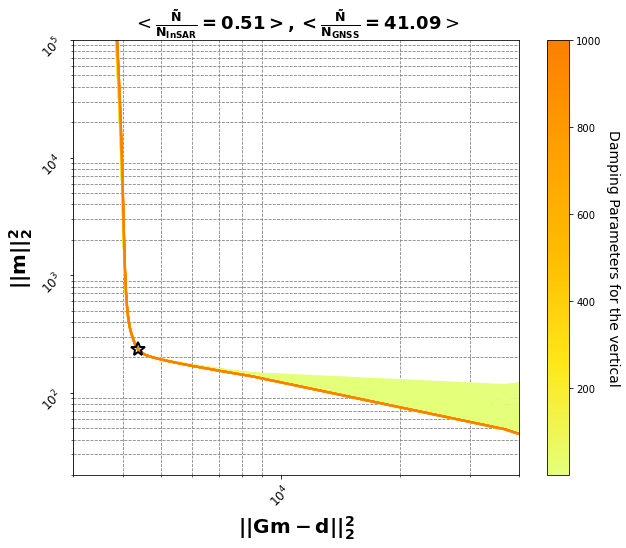

In [270]:
y=df_search.groupby('beta').model_norm.apply(np.array).values
ys=np.stack( y, axis=0 )

x=df_search.groupby('beta').misfit_data.apply(np.array).values
xs=np.stack( x, axis=0 )

yint = np.array(dict_unique['beta'])

fig, ax = plt.subplots(figsize=(10,8))

lc = multiline(xs, ys, yint, cmap='Wistia', lw=2, ls='-')
# magma_r; Wistia
ax.plot(df_search['misfit_data'][MinAlpha_median_idx], df_search['model_norm'][MinAlpha_median_idx], '*', markersize=15, 
         markeredgecolor='black',markerfacecolor='none', alpha=1, markeredgewidth = 2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, color='0.5',linestyle='--', which='minor')
ax.set_xlabel(r'$\mathbf{\vert\vert Gm-d \vert\vert_2^2}$', fontsize=20)
ax.set_ylabel(r'$\mathbf{\vert\vert m \vert\vert_2^2}$', fontsize=20)
ax.tick_params(axis='x', labelsize=12, rotation=45, which='both')
ax.tick_params(axis='y', labelsize=12, rotation=45, which='both') 
ax.set_xlim([3*10**3,4*10**4])
ax.set_ylim([2*10**1,10**5])

ax.set_title(r'$<\mathbf{\frac{\~ N}{N_{InSAR}}=%0.2f>, <\frac{\~ N}{N_{GNSS}}=%0.2f}>$' 
             % (1/(wI_search**2), 1/(wG_search**2)), fontsize=18)
axcb = fig.colorbar(lc)
axcb.set_label('Damping Parameters for the vertical', rotation=270, labelpad=18, fontsize=14)

fig.savefig('L-curve.pdf')

Optimal alpha is 13.111000


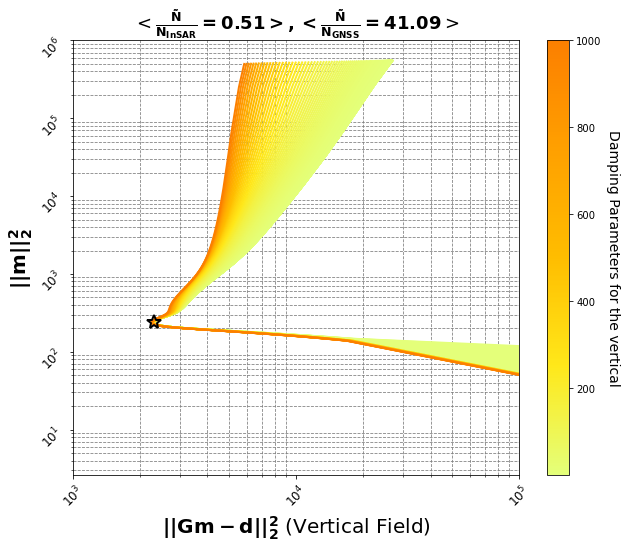

In [286]:
y=df_search.groupby('beta').model_norm.apply(np.array).values
ys=np.stack( y, axis=0 )

x=df_search.groupby('beta').misfit_z_true.apply(np.array).values
xs=np.stack( x, axis=0 )

yint = np.array(dict_unique['beta'])

fig, ax = plt.subplots(figsize=(10,8))

lc = multiline(xs, ys, yint, cmap='Wistia', lw=2, ls='-')
# magma_r; Wistia


Nmin=np.argmin(xs,axis=1)
MinAlpha_median_idx=int(np.median(Nmin))
MinAlpha_median=dict_unique['alpha'][MinAlpha_median_idx]
print("Optimal alpha is %f" % MinAlpha_median)

ax.plot(df_search['misfit_z_true'][MinAlpha_median_idx], df_search['model_norm'][MinAlpha_median_idx], '*', markersize=15, 
         markeredgecolor='black',markerfacecolor='none', alpha=1, markeredgewidth = 2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, color='0.5',linestyle='--', which='minor')
ax.set_xlabel(r'$\mathbf{\vert\vert Gm-d \vert\vert_2^2}$ (Vertical True Field)', fontsize=20)
ax.set_ylabel(r'$\mathbf{\vert\vert m \vert\vert_2^2}$', fontsize=20)
ax.tick_params(axis='x', labelsize=12, rotation=45, which='both')
ax.tick_params(axis='y', labelsize=12, rotation=45, which='both') 
ax.set_xlim([1*10**3,10**5])
# ax.set_ylim([2*10**1,10**5])

ax.set_title(r'$<\mathbf{\frac{\~ N}{N_{InSAR}}=%0.2f>, <\frac{\~ N}{N_{GNSS}}=%0.2f}>$' 
             % (1/(wI_search**2), 1/(wG_search**2)), fontsize=18)
axcb = fig.colorbar(lc)
axcb.set_label('Damping Parameters for the vertical', rotation=270, labelpad=18, fontsize=14)

fig.savefig('L-curve_VERTICAL_true.pdf')

Optimal alpha is 14.166000


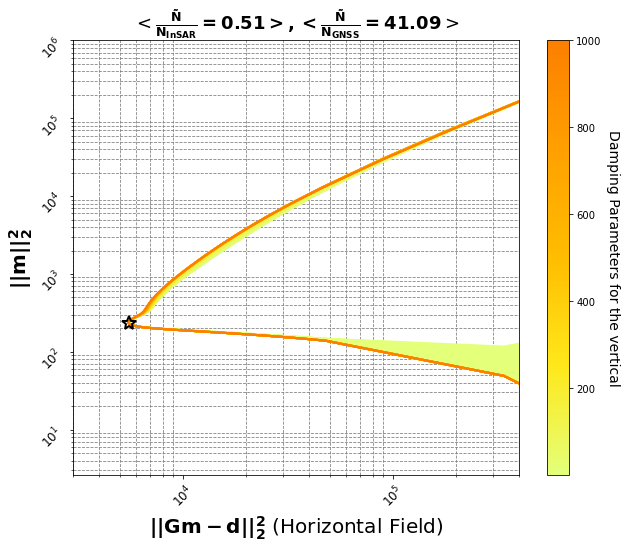

In [285]:
y=df_search.groupby('beta').model_norm.apply(np.array).values
ys=np.stack( y, axis=0 )

x=df_search.groupby('beta').misfit_hori_true.apply(np.array).values
xs=np.stack( x, axis=0 )

yint = np.array(dict_unique['beta'])

fig, ax = plt.subplots(figsize=(10,8))

lc = multiline(xs, ys, yint, cmap='Wistia', lw=2, ls='-')
# magma_r; Wistia


Nmin=np.argmin(xs,axis=1)
MinAlpha_median_idx=int(np.median(Nmin))
MinAlpha_median=dict_unique['alpha'][MinAlpha_median_idx]
print("Optimal alpha is %f" % MinAlpha_median)

ax.plot(df_search['misfit_hori_true'][MinAlpha_median_idx], df_search['model_norm'][MinAlpha_median_idx], '*', markersize=15, 
         markeredgecolor='black',markerfacecolor='none', alpha=1, markeredgewidth = 2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, color='0.5',linestyle='--', which='minor')
ax.set_xlabel(r'$\mathbf{\vert\vert Gm-d \vert\vert_2^2}$ (Horizontal True Field)', fontsize=20)
ax.set_ylabel(r'$\mathbf{\vert\vert m \vert\vert_2^2}$', fontsize=20)
ax.tick_params(axis='x', labelsize=12, rotation=45, which='both')
ax.tick_params(axis='y', labelsize=12, rotation=45, which='both') 
ax.set_xlim([3*10**3,4*10**5])

ax.set_title(r'$<\mathbf{\frac{\~ N}{N_{InSAR}}=%0.2f>, <\frac{\~ N}{N_{GNSS}}=%0.2f}>$' 
             % (1/(wI_search**2), 1/(wG_search**2)), fontsize=18)
axcb = fig.colorbar(lc)
axcb.set_label('Damping Parameters for the vertical', rotation=270, labelpad=18, fontsize=14)

fig.savefig('L-curve_HORIZONTAL_true.pdf')

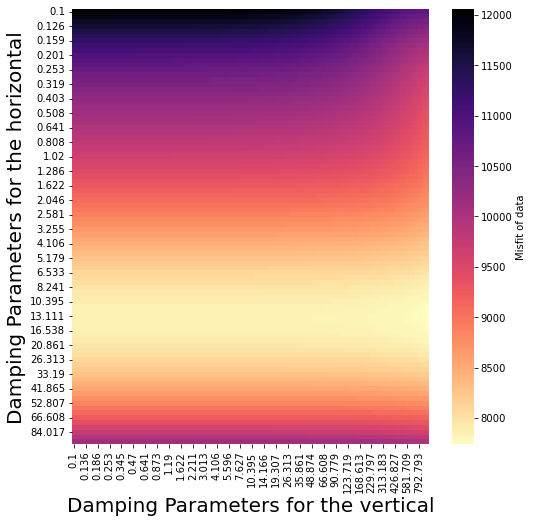

In [290]:
df_misfit = df_search.loc[:,['alpha','beta','misfit_3D_true']]

scale = 1
tickFont = 20
fig, ax = plt.subplots(figsize = (8*scale,8*scale), ncols = ncols, nrows = nrows, sharex=True, sharey=True)
df_misfit_zoomed = df_misfit[(df_misfit['alpha'] <= 100) & (df_misfit['alpha'] >= 0.1)]
df_misfit_zoomed = df_misfit_zoomed.pivot_table(index='alpha', columns='beta', values='misfit_3D_true')
sns.heatmap(df_misfit_zoomed, cmap='magma_r', cbar_kws={'label': 'Misfit of data'})
plt.ylabel('Damping Parameters for the horizontal', fontsize=20)
plt.xlabel('Damping Parameters for the vertical', fontsize=20)
fig.savefig('HeatMap_3D_true.pdf')

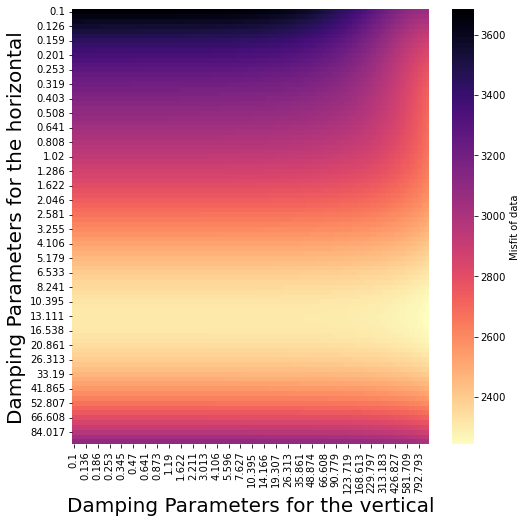

In [291]:
df_misfit = df_search.loc[:,['alpha','beta','misfit_z_true']]

scale = 1
tickFont = 20
fig, ax = plt.subplots(figsize = (8*scale,8*scale), ncols = ncols, nrows = nrows, sharex=True, sharey=True)
df_misfit_zoomed = df_misfit[(df_misfit['alpha'] <= 100) & (df_misfit['alpha'] >= 0.1)]
df_misfit_zoomed = df_misfit_zoomed.pivot_table(index='alpha', columns='beta', values='misfit_z_true')
sns.heatmap(df_misfit_zoomed, cmap='magma_r', cbar_kws={'label': 'Misfit of data'})
plt.ylabel('Damping Parameters for the horizontal', fontsize=20)
plt.xlabel('Damping Parameters for the vertical', fontsize=20)
fig.savefig('HeatMap_VERTICAL_true.pdf')

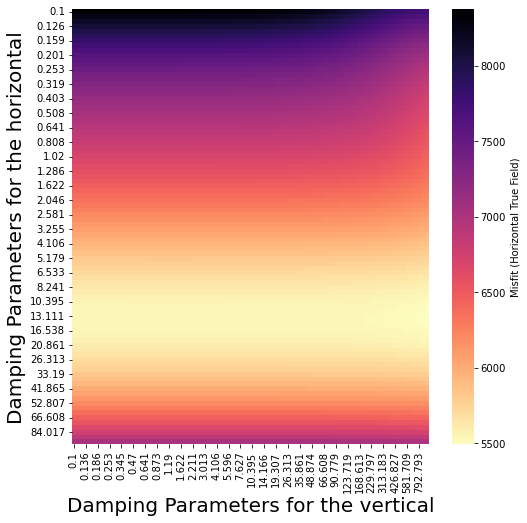

In [293]:
df_misfit = df_search.loc[:,['alpha','beta','misfit_hori_true']]

scale = 1
tickFont = 20
fig, ax = plt.subplots(figsize = (8*scale,8*scale), ncols = ncols, nrows = nrows, sharex=True, sharey=True)
df_misfit_zoomed = df_misfit[(df_misfit['alpha'] <= 100) & (df_misfit['alpha'] >= 0.1)]
df_misfit_zoomed = df_misfit_zoomed.pivot_table(index='alpha', columns='beta', values='misfit_hori_true')
sns.heatmap(df_misfit_zoomed, cmap='magma_r', cbar_kws={'label': 'Misfit (Horizontal True Field)'})
plt.ylabel('Damping Parameters for the horizontal', fontsize=20)
plt.xlabel('Damping Parameters for the vertical', fontsize=20)
fig.savefig('HeatMap_HORIZONTAL_true.pdf')